In [1]:
import os
import time

import numpy as np
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from dataloader import CityScapesDataset
from transformations import *

In [2]:
BATCH_SIZE = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
root = "C:/Users/itber/Documents/datasets/cityscapes"

test_transform = transforms.Compose([
    ToTensor(),
    Normalize()
])

In [4]:
from dataloader import CityScapesDataset

train_dataset = CityScapesDataset(root, transform=test_transform, split='train', label_map='trainId') 
valid_dataset = CityScapesDataset(root, transform=test_transform, split='val', label_map='trainId')
test_dataset = CityScapesDataset(root, transform=test_transform, split='test', label_map='trainId')

NUM_SEG_CLASSES = len(test_dataset.trainid_2_name)
NUM_SEG_CLASSES

20

In [8]:
from labels import labels

def convert_to_numpy(image):
    if not isinstance(image, np.ndarray):
        if len(image.shape) == 2:
            image = image.detach().cpu().numpy()
        else:
            image = image.detach().cpu().numpy().transpose(1, 2, 0)

    return image

def get_color_mask(mask, labels, id_type='id'):
    try:
        h, w = mask.shape
    except ValueError:
        mask = mask.squeeze(-1)
        h, w = mask.shape

    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    if id_type == 'id':
        for lbl in labels:
            color_mask[mask == lbl.id] = lbl.color
    elif id_type == 'trainId':
        for lbl in labels:
            if (lbl.trainId != 255) | (lbl.trainId != -1):
                color_mask[mask == lbl.trainId] = lbl.color

    return color_mask


def plot_items(left, mask, depth, labels=None, num_seg_labels=34, id_type='id'):
    left = convert_to_numpy(left)
    mask = convert_to_numpy(mask)
    depth = convert_to_numpy(depth)

    # unnormalize left image
    left = (left*np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    # cmaps: 'prism', 'terrain', 'turbo', 'gist_rainbow_r', 'nipy_spectral_r'
    
    
    _, ax = plt.subplots(1, 3, figsize=(15,10))
    ax[0].imshow(left)
    ax[0].set_title("Left Image")

    if labels:
        color_mask = get_color_mask(mask, labels, id_type)
        ax[1].imshow(color_mask)
    else:
        cmap = mpl.colormaps.get_cmap('nipy_spectral_r').resampled(num_seg_labels)
        ax[1].imshow(mask, cmap=cmap)

    ax[1].set_title("Seg Mask")
    ax[2].imshow(depth, cmap='plasma')
    ax[2].set_title("Depth")

In [9]:
from torchvision.models import mobilenet_v3_small
from model import MobileNetV3Backbone, LightWeightRefineNet, MultiTaskNetwork


mobilenet_backbone = mobilenet_v3_small(weights='IMAGENET1K_V1')

encoder = MobileNetV3Backbone(mobilenet_backbone.features)
decoder = LightWeightRefineNet(NUM_SEG_CLASSES)
model = MultiTaskNetwork(encoder, decoder).to(DEVICE)

In [10]:
# weights_path_4 = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_95.pth" # 1/4 res model
# weights_path_2 = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_19_ft_half.pth" # 1/2 res model
weights_path = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models\model_24_ft_full.pth" # full res model

model.load_state_dict(torch.load(weights_path))
model.eval();

notes:

- sample 1000 exhibits a failure mode (lights?)
- sample 1500 exhibits a catastrophic segmentaiton failure
- samples 1200, 2000 are good

In [309]:
sample = valid_dataset[123]
left, mask, depth = sample['left'], sample['mask'], sample['depth']
left, mask, depth = left.to(DEVICE), mask.to(DEVICE), depth.to(DEVICE)

In [310]:
with torch.no_grad():
    # get predictions
    pred_seg, pred_depth = model(left.unsqueeze(0))

In [311]:
def get_pred_from_weights(model, weights_path, sample):
    model.load_state_dict(torch.load(weights_path))
    model.eval()

    with torch.no_grad():
        pred_seg, pred_depth = model(sample)
        
    return pred_seg, pred_depth

In [312]:
# pred_seg_4, pred_depth_4 = get_pred_from_weights(model, weights_path_4, left.unsqueeze(0))
# pred_seg_2, pred_depth_2 = get_pred_from_weights(model, weights_path_2, left.unsqueeze(0))
pred_seg, pred_depth = get_pred_from_weights(model, weights_path, left.unsqueeze(0))

In [313]:
# # ballpark timer
# num_iters = 100
# times = []
# # warmup
# for i in range(30):
#     _, _ = model(left.unsqueeze(0))

# for i in range(num_iters):
#     t = time.perf_counter()
#     _, _ = model(left.unsqueeze(0))
#     t_end = time.perf_counter() - t
#     times.append(t_end)

# t_mean = np.mean(times)
# t_std = np.std(times)

Ground Truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


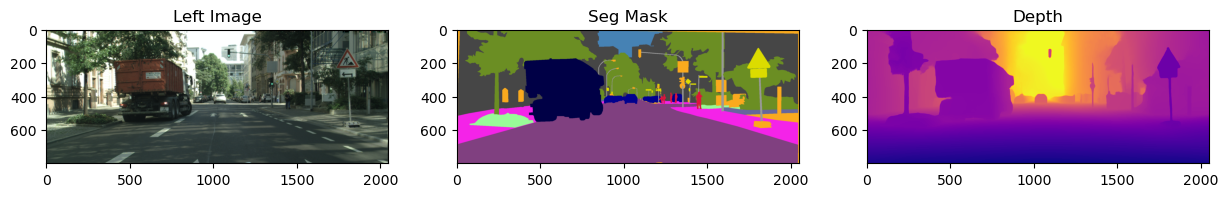

In [314]:
plot_items(left, mask, depth.squeeze(0), labels, NUM_SEG_CLASSES, id_type='trainId')

full res model prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


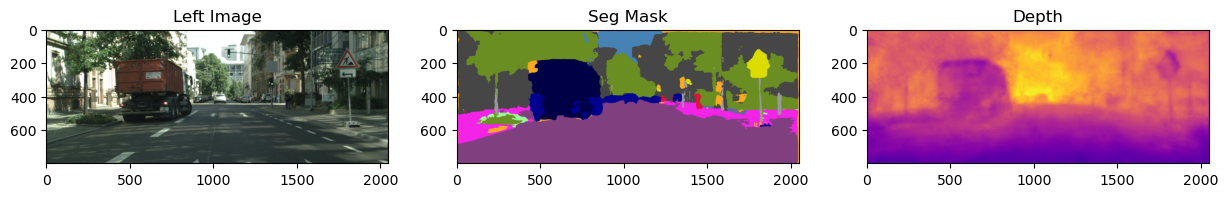

In [315]:
plot_items(left, pred_seg.argmax(dim=1).squeeze(0), pred_depth.squeeze(0), labels, NUM_SEG_CLASSES, id_type='trainId')

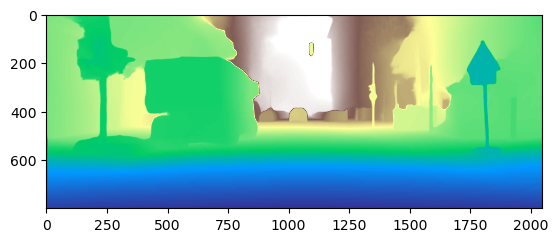

In [316]:
# cmaps: 'prism', 'terrain', 'turbo', 'gist_rainbow_r', 'nipy_spectral_r'
# plt.imshow(convert_to_numpy(torch.exp(depth*5)), cmap='nipy_spectral_r')
plt.imshow(convert_to_numpy(depth), cmap='terrain')

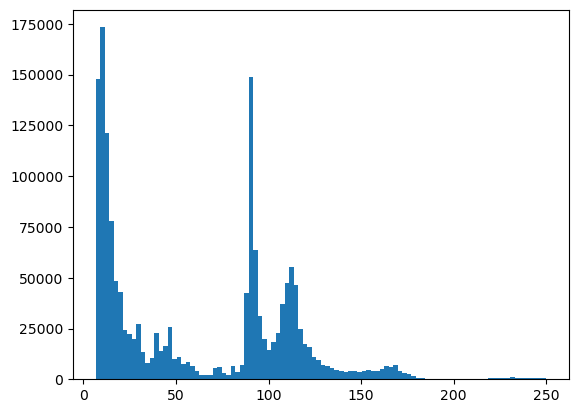

In [126]:
plt.hist(np.exp(depth.cpu().numpy().flatten()*5), bins=100);

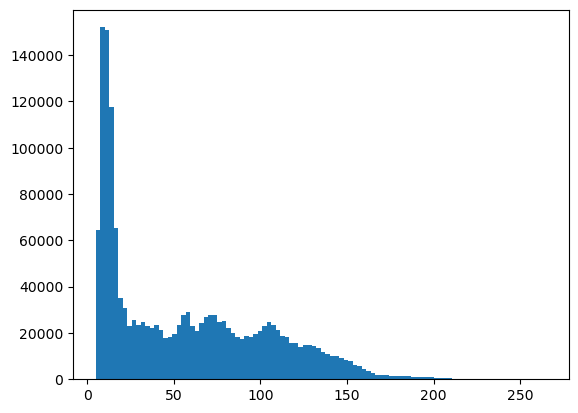

In [127]:
plt.hist(np.exp(pred_depth.cpu().numpy().flatten()*5), bins=100);

## Get true and predicted depth distributions

Predict one sample at a time at full res to avoid overloading the GPU

In [74]:
idxs = np.random.choice(len(test_dataset), size=(94,), replace=False)
idxs

array([1208,  439,  885,  228,  123,  362, 1310,  784,  757, 1032,  101,
        284, 1324, 1268, 1189,  992, 1065,  792,  735,  277, 1263, 1461,
       1039,  744,  587,  527, 1025,  429, 1130, 1299, 1486,  829, 1088,
         65, 1027,   37,   89,  702,  337,  902,  646, 1301,   92,  958,
        421,  545,   42, 1308,  367,  832,  740, 1287, 1203,  761, 1356,
       1076,  842, 1084, 1141,  435,   18, 1182,  934, 1035, 1135,  558,
       1238,  714,  470, 1047, 1506, 1387,   40,  997, 1286,  540,  733,
       1187,  945, 1131, 1228,  289,  246,  180, 1311,  495, 1193,  449,
        379,  358,  374,  280,  758,  129])

In [75]:
model.load_state_dict(torch.load(weights_path))
model.eval()

# pred_segs = []
depths = []
pred_depths = []
with torch.no_grad():
    for i in idxs:
        sample = test_dataset[i]
        left, mask, depth = sample['left'], sample['mask'], sample['depth']
        left, mask, depth = left.to(DEVICE), mask.to(DEVICE), depth.to(DEVICE)
        pred_seg, pred_depth = model(left.unsqueeze(0))

        # pred_segs.append(pred_seg.cpu().numpy())
        depths.append(depth.cpu().numpy())
        pred_depths.append(pred_depth.squeeze(0).cpu().numpy())


depths = np.vstack(depths)
pred_depths = np.vstack(pred_depths)

In [118]:
pred_depths.shape

(94, 800, 2048)

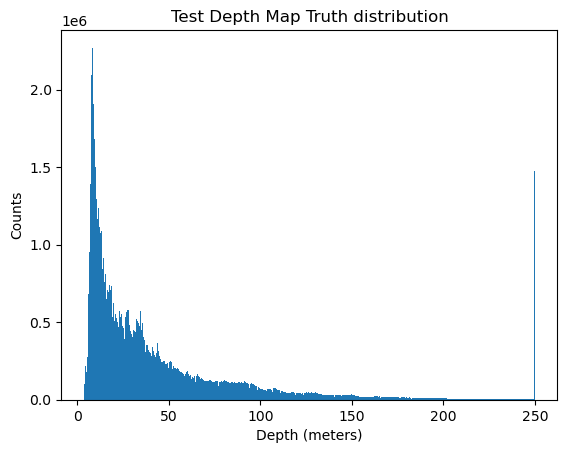

In [76]:
plt.hist(np.exp(depths.flatten()*5), bins=1000);
plt.title("Test Depth Map Truth distribution");
plt.xlabel('Depth (meters)');
plt.ylabel('Counts');

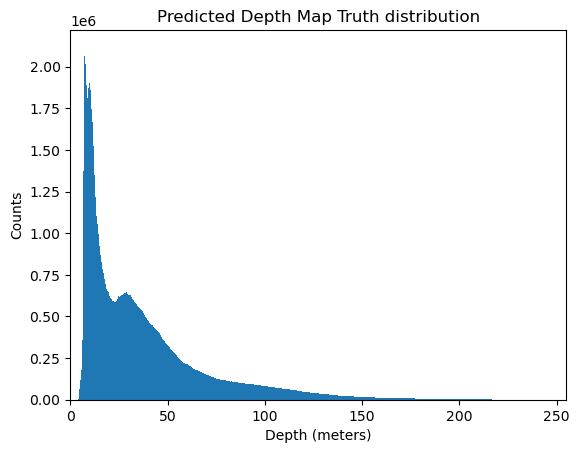

In [77]:
plt.hist(np.exp(pred_depths.flatten()*5), bins=1000);
plt.title("Predicted Depth Map Truth distribution");
plt.xlabel('Depth (meters)');
plt.ylabel('Counts');
plt.xlim(0, 255);

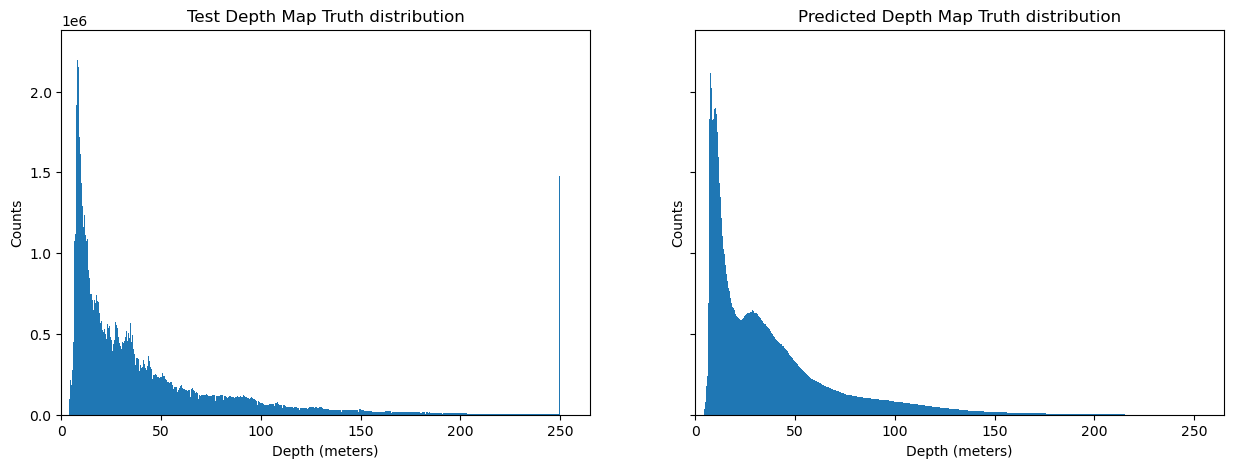

In [78]:
_, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].hist(np.exp(depths.flatten()*5), bins=1000);
ax[0].set_title("Test Depth Map Truth distribution");
ax[0].set_xlabel('Depth (meters)');
ax[0].set_ylabel('Counts');
ax[0].set_xlim(0, 265);

ax[1].hist(np.exp(pred_depths.flatten()*5), bins=1000);
ax[1].set_title("Predicted Depth Map Truth distribution");
ax[1].set_xlabel('Depth (meters)');
ax[1].set_ylabel('Counts');
ax[1].set_xlim(0, 265);

#### Let's visualize the depths in relative to vertical pixel position

We can continue using the actual predicted depth, now we can also add in the vertical pixel location of the predicted depth value. Since the vertical pixels should have more close depth values at the bottom of the image. We need to place the depth data into terms of depth value VS vertical pixel location

In [134]:
depth_2d = np.exp(depths*5).transpose(1, 0, 2).reshape((800, -1)).transpose(1, 0)
pred_depth_2d = np.exp(pred_depths*5).transpose(1, 0, 2).reshape((800, -1)).transpose(1, 0)

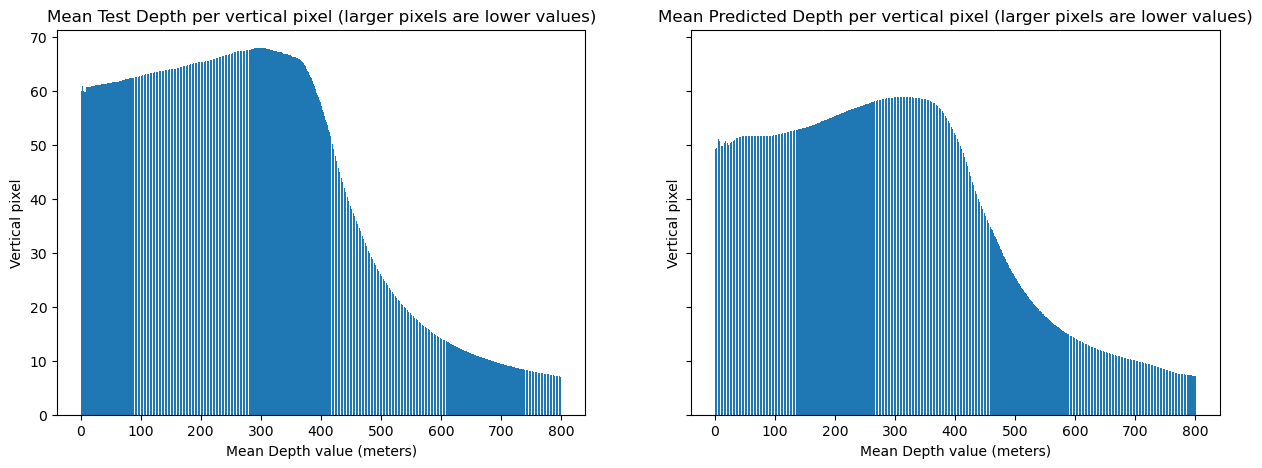

In [135]:
_, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].bar(np.arange(1, 801), depth_2d.mean(axis=0));
ax[0].set_title('Mean Test Depth per vertical pixel (larger pixels are lower values)');
ax[0].set_xlabel('Mean Depth value (meters)');
ax[0].set_ylabel('Vertical pixel');

ax[1].bar(np.arange(1, 801), pred_depth_2d.mean(axis=0))
ax[1].set_title('Mean Predicted Depth per vertical pixel (larger pixels are lower values)');
ax[1].set_xlabel('Mean Depth value (meters)');
ax[1].set_ylabel('Vertical pixel');

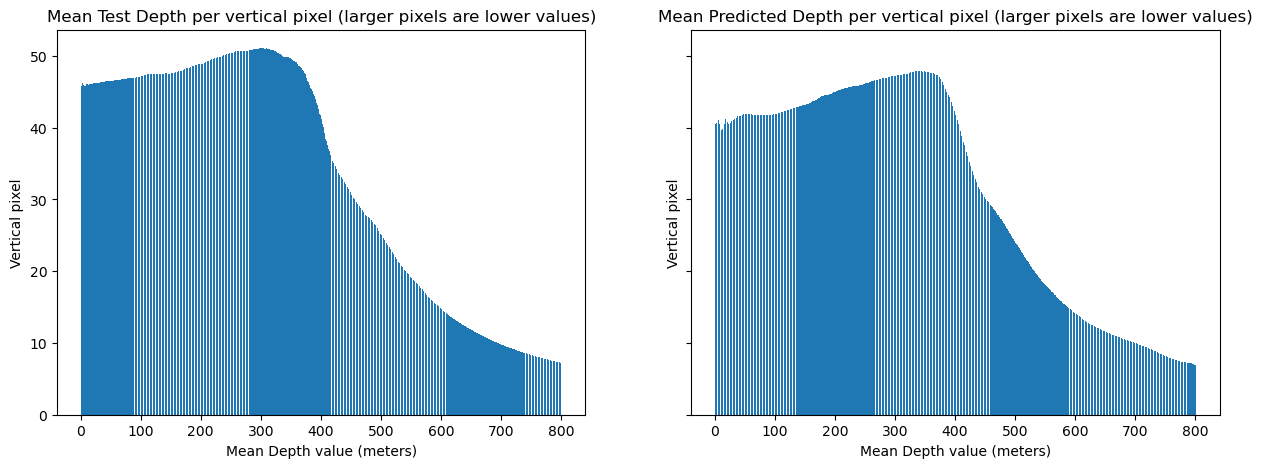

In [136]:
_, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].bar(np.arange(1, 801), np.median(depth_2d, axis=0));
ax[0].set_title('Mean Test Depth per vertical pixel (larger pixels are lower values)');
ax[0].set_xlabel('Mean Depth value (meters)');
ax[0].set_ylabel('Vertical pixel');

ax[1].bar(np.arange(1, 801), np.median(pred_depth_2d, axis=0))
ax[1].set_title('Mean Predicted Depth per vertical pixel (larger pixels are lower values)');
ax[1].set_xlabel('Mean Depth value (meters)');
ax[1].set_ylabel('Vertical pixel');

It seems like the model has learned two distributions, a background distribution with a peak around 4 and a foreground distribution with a peak around 30. Let's see if we can bring out these distributions. The overall distribution contains a long tail which is characteristic of the fact that only a small portion of an image will contain far away depth data.

In [137]:
depth_cnts, depth_bins = np.histogram(np.exp(depths.flatten()*5).reshape((-1, 1)), bins=800)
pred_depth_cnts, pred_depth_bins = np.histogram(np.exp(pred_depths.flatten()*5).reshape((-1, 1)), bins=800)

In [138]:
med_depth = np.median(depth_2d, axis=0)
med_pred_depth = np.median(pred_depth_2d, axis=0)

In [ ]:
cnts, bins = np.histogram(pred_depths.flatten(), bins=800, density=True)

In [165]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

gmm = GaussianMixture(n_components=2, covariance_type='full', tol=0.001, max_iter=1000, init_params='random_from_data')
gmm.fit(bins[:-1].reshape((-1, 1)), cnts.reshape((-1, 1)))

GaussianMixture(init_params='random_from_data', max_iter=1000, n_components=2)

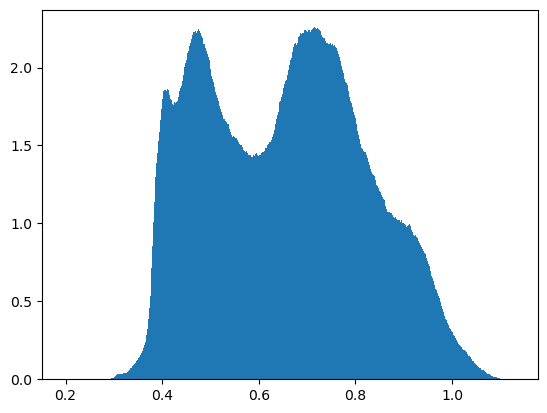

In [233]:
plt.hist(pred_depths.flatten(), bins=1000, density=True);

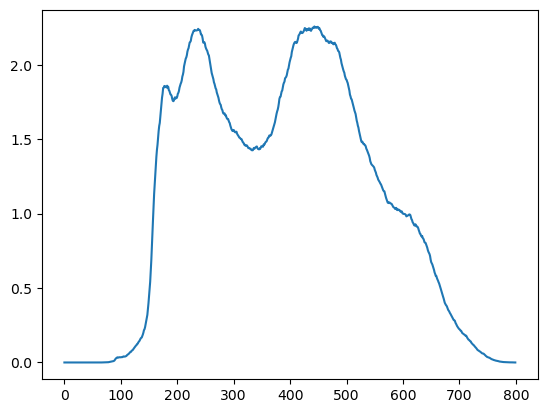

In [211]:
plt.plot(cnts)

In [226]:
gmm = GaussianMixture(n_components=2, covariance_type='spherical', tol=0.001, max_iter=10000, init_params='random_from_data')
gmm.fit(bins[:-1].reshape((-1, 1)), cnts.reshape((-1, 1)))

GaussianMixture(covariance_type='spherical', init_params='random_from_data',
                max_iter=10000, n_components=2)

Text(0, 0.5, 'Density')

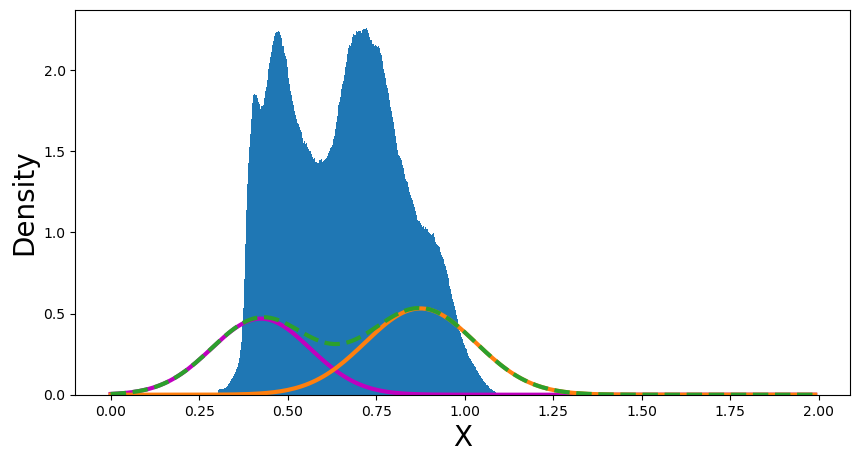

In [248]:
from scipy.stats import norm

# find useful parameters
mean = gmm.means_  
covs  = gmm.covariances_
weights = gmm.weights_

# create necessary things to plot
x_axis = np.arange(0, 2, 0.01)
# y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
# y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian
y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0])))#*weights[0] # 1st gaussian
y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1])))# *weights[1] # 2nd gaussian

y_axis0 = (y_axis0/y_axis0.max())*weights[0]
y_axis1 = (y_axis1/y_axis1.max())*weights[1]

fig = plt.figure(figsize=(10, 5))
plt.hist(pred_depths.flatten(), bins=1000, density=True)
plt.plot(x_axis, y_axis0, lw=3, c='m')
plt.plot(x_axis, y_axis1, lw=3, c='C1')
plt.plot(x_axis, y_axis0+y_axis1, lw=3, c='C2', ls='dashed')
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

In [247]:
y_axis0.max()*weights[0], y_axis1.max()*weights[1]

(1.338387819261578, 1.3608020564913768)

In [241]:
mean, covs, weights

(array([[0.42412185],
        [0.8748904 ]]),
 array([0.01949664, 0.02424246]),
 array([0.46864174, 0.53135826]))

### Measure inference speed

In [142]:
torch.backends.cudnn.benchmark = True 

In [143]:
left.shape

torch.Size([3, 800, 2048])

In [144]:
rescaled_sample = Rescale(400, 1024)(sample)
rescaled_left = rescaled_sample['left'].to(DEVICE)

In [145]:
model.to(DEVICE);

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(rescaled_left.unsqueeze(0))
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _, _ = model(rescaled_left.unsqueeze(0))
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn, std_syn)

18.960818525950113 0.35123538043165264


In [74]:
1/(18/1000)

55.55555555555556

In [72]:
print(mean_syn, std_syn)

18.696630674997966 0.43791827323157734


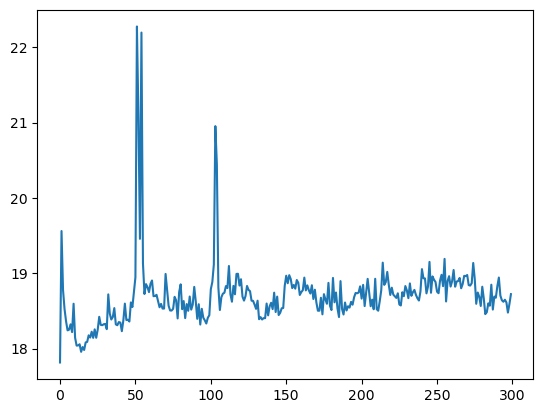

In [73]:
plt.plot(timings)